## Imports

In [34]:
# The basics
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import time as t

# Preprocessing
from sklearn.preprocessing import MultiLabelBinarizer

# Natural Language Processing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# Models
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Model evaluation
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, roc_auc_score

# Build in News and Tweets

In [4]:
# NLP processing from the nltk package
# Instantiate tokenizer to break text into lists of words
#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9_@-]+')
# Instantiate lemmatizer to turn plural words into singular for better comparison
lemmatizer = WordNetLemmatizer()

## Elon Musk's Tweets

In [5]:
elon = pd.read_csv('twitter/elonmusk_tweets.csv')

# A bit of preprocessing and creating the datetime
elon.text = elon.text.str.lstrip('b')
elon.created_at = pd.to_datetime(elon.created_at)
elon['date'] = elon.created_at.apply(lambda x: x.date())

# First let's turn each title into a list of words
elon['nlp_text'] = elon.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
elon.nlp_text = elon.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
elon.nlp_text = elon.nlp_text.apply(lambda x: ' '.join(x))

# Recombine and create database with datetime index and nlp text ready to go
elon.nlp_text = elon.nlp_text + ' '
elon = elon.groupby('date')['nlp_text'].sum()
elon = pd.DataFrame(elon)
elon.columns = ['elon_tweet']

## Tesla company tweets

In [6]:
tesla = pd.read_csv('twitter/Tesla_tweets.csv')

# A bit of preprocessing and creating the datetime
tesla.text = tesla.text.str.lstrip('b')
tesla.created_at = pd.to_datetime(tesla.created_at)
tesla['date'] = tesla.created_at.apply(lambda x: x.date())

# First let's turn each title into a list of words
tesla['nlp_text'] = tesla.text.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
tesla.nlp_text = tesla.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
tesla.nlp_text = tesla.nlp_text.apply(lambda x: ' '.join(x))

# Recombine and create database with datetime index and nlp text ready to go
tesla.nlp_text = tesla.nlp_text + ' '
tesla = tesla.groupby('date')['nlp_text'].sum()
tesla = pd.DataFrame(tesla)
tesla.columns = ['tesla_tweet']

## Techmeme headlines

In [7]:
techmeme = pd.read_csv('web_scraping/techmeme.csv', index_col=0)

# A bit of preprocessing and creating the datetime
techmeme['date_time'] = pd.to_datetime(techmeme.date)
techmeme.date = techmeme.date_time.apply(lambda x: x.date())
# Turn list into actual list
techmeme.extra_sources = techmeme.extra_sources.apply(lambda x: ast.literal_eval(x))

techmeme['sources'] = techmeme.extra_sources.copy()
# Ben helped me with this lovely for loop to combine source columns
for i, list_ in enumerate(techmeme.sources):
    list_.append(techmeme.original_source[i])

# Prepare titles to be combined    
techmeme.original_title = techmeme.original_title.apply(lambda x: x.replace('\n', ''))
techmeme.extra_titles = techmeme.extra_titles.apply(lambda x: x.lstrip('[').rstrip(']'))
techmeme['titles'] = techmeme.original_title + ' ' + techmeme.extra_titles

# First let's turn each title into a list of words
techmeme['nlp_text'] = techmeme.titles.apply(lambda x: tokenizer.tokenize(x.lower()))
# Then we'll use the lemmatizer to change plurals to singulars to group them
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
# And rejoin the lists of words to one string for the count vectorizer
techmeme.nlp_text = techmeme.nlp_text.apply(lambda x: ' '.join(x))

# Rename columns
techmeme.columns = ['date', 'original_source', 'original_title', 'extra_sources',
       'extra_titles', 'date_time', 'news_sources', 'titles', 'news_text']

# Combine entries by data and create new dataframe with datetime index
techmeme.news_text = techmeme.news_text + ' '
techmeme = techmeme.groupby('date')['news_sources', 'news_text'].sum()

# Prep Evaluation Functions

In [2]:
# My go=to for classification evaluation
def eval_sklearn_model(y_true, predictions, model=None, X=None):
    """This function takes the true values for y and the predictions made by the model and prints out the confusion matrix along with Accuracy, Precision, and, if model and X provided, Roc_Auc Scores."""
    cnf_matrix = confusion_matrix(y_true, predictions)

    print('True Negative: ', cnf_matrix[0, 0], '| False Positive: ', cnf_matrix[0, 1])
    print('False Negative: ', cnf_matrix[1, 0], '| True Positive: ', cnf_matrix[1, 1], '\n')

    sensitivity = cnf_matrix[1, 1]/ (cnf_matrix[1, 0] + cnf_matrix[1, 1])
    specificity = cnf_matrix[0, 0]/ (cnf_matrix[0, 1] + cnf_matrix[0, 0])

    print('Sensitivity (TP/ TP + FN): ', sensitivity)
    print('Specificity (TN/ TN + FP): ', specificity, '\n')

    print('Accuracy: ', accuracy_score(y_true, predictions, normalize=True))
    print('Precision: ', precision_score(y_true, predictions))
    if model != None:
        print('Roc-Auc: ', roc_auc_score(y_true, [x[1] for x in model.predict_proba(X)]))
    else:
        pass
    print('\n')

In [3]:
# This is used to calculate the profit that would be expected if a model has been used to tell when to buy or sell
def profit_calculator(dataframe, predict_col, early_stop=None):  
    money_counter = 0
    transactions = 0
    own = False
    last_buy = 0
    current_price = 0
    for num, i in enumerate(dataframe.iloc[:early_stop].iterrows()):
        if i[1][predict_col] == 1 and own == False:
            money_counter -= i[1]['next_day_open']
            own = True
            transactions += 1
            last_buy = i[1]['next_day_open']
        elif i[1][predict_col] == 0 and own == True:
            money_counter += i[1]['next_day_open']
            own = False
            transactions += 1
        else:
            pass
        current_price=i[1]['next_day_open']
    print('Own?', own)
    print('Last Buying price: $', last_buy)
    print('Current price: $', current_price)
    print('Cash? $', money_counter)
    if own == True:
        print('Profit: $', current_price + money_counter)
    else:
        print('Profit: $', money_counter)
    print('Number of Transactins:', transactions)
    print('Cost of transactions: $', transactions*5)

In [38]:
def plot_profit(dataframe, predict_col, early_stop=None):  
    X = []
    y = []
    money_counter = 0
    transactions = 0
    own = False
    last_buy = 0
    current_price = 0
    for num, i in enumerate(dataframe.iloc[:early_stop].iterrows()):
        if i[1][predict_col] == 1 and own == False:
            money_counter -= i[1]['next_day_open']
            own = True
            transactions += 1
            last_buy = i[1]['next_day_open']
            X.append(i[0])
            y.append(money_counter + i[1]['next_day_open'])
        elif i[1][predict_col] == 0 and own == True:
            money_counter += i[1]['next_day_open']
            own = False
            transactions += 1
            X.append(i[0])
            y.append(money_counter)
        else:
            pass
        current_price=i[1]['next_day_open']
    fig, ax = plt.subplots()
    ax=pd.DataFrame(data=y, index=X)[0].plot(figsize=(12,8), title= 'Profit over Time', fontsize=14, ax=ax)
    plt.title('Profit over Time', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Stock Price', fontsize=16)
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    ax.yaxis.set_major_formatter(tick) 
    plt.yticks()
    plt.xticks(rotation=25)
    plt.show()
    return X, y

# First Models

# Combine them onto stock data

In merging, I noticed that I was not retaining the same amounts of information.  I realized that since I do not have stock information on weekends, I have nothing to link tweets or news that happens over the weekend.  I should push this to help predict Monday prices, but I am not yet sure how to do that.

In [339]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [340]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [341]:
stock.tail()

,close,volume,open,high,low,news_sources,news_text,tesla_tweet,elon_tweet
date,,,,,,,,,
2017-11-16,312.50,5794409.0,313.99,318.14,311.30,NaN,NaN,NaN,NaN
2017-11-17,315.05,13720830.0,325.67,326.67,313.15,NaN,NaN,going into plaid http t co ouu9s7cuwi bamf htt...,tesla semi http t co 7vlz7f46ji 0 to 100 km h ...
2017-11-20,308.74,8241821.0,313.79,315.50,304.75,NaN,NaN,NaN,@schesnais good point
2017-11-21,317.81,7256381.0,310.86,318.23,308.71,NaN,NaN,NaN,initial hat offering going great w over 300k i...
2017-11-22,312.60,4913283.0,316.77,317.42,311.84,NaN,NaN,NaN,NaN


### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

# Run ARIMA Model

In [342]:
mod = sm.tsa.statespace.SARIMAX(stock.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                 1866
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -5456.155
Date:                            Wed, 20 Dec 2017   AIC                          10924.310
Time:                                    12:30:04   BIC                          10957.499
Sample:                                06-29-2010   HQIC                         10936.539
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2551      0.425      0.601      0.548      -0.577       1.087
ma.L1         -0.2205      0.425     -0.518      0.604      -1.054       0.613
ma.L2          0.0068      0.027      0.253      0.800      -0.046       0.059
ma.L3         -0.0481      0.018     -2.700      0.007      -0.083      -0.013
ma.S.L80      -0.9995      2.558     -0.391      0.696      -6.013       4.014
sigma2        22.9819     58.554      0.392      0.695     -91.782     137.746
===================================================================================
Ljung-Box (Q):                       33.16   Jarque-Bera (JB):              1844.42
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              40.33   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [343]:
stock['forecast'] = results.predict(dynamic=False)

In [344]:
stock['next_day_open'] = stock.open.shift(-1) 

In [345]:
stock['target'] = stock.close.shift(-1)

# Use CountVectorizer

In [346]:
temp_df = stock[stock.news_text.notnull()]
cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=1000)
cvec.fit(temp_df.news_text.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _news_"
stock = stock.join(cvec_df).drop('news_text',1)

temp_df = stock[stock.tesla_tweet.notnull()]
cvec.fit(temp_df.tesla_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _tesla_"
stock = stock.join(cvec_df).drop('tesla_tweet',1)

temp_df = stock[stock.elon_tweet.notnull()]
cvec.fit(temp_df.elon_tweet.dropna())
cvec_df  = pd.DataFrame(cvec.transform(temp_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = temp_df.index
cvec_df.columns += " _elon_"
stock = stock.join(cvec_df).drop('elon_tweet',1)

del temp_df

In [347]:
stock.news_sources = stock.news_sources.fillna('')
mlb = MultiLabelBinarizer()
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

In [348]:
stock = stock.fillna(0)

In [349]:
stock.head()

,close,volume,open,high,low,forecast,next_day_open,target,000 _news_,10 _news_,...,digitaltrends.com,documentcloud.org,everythingiCafe,iDownloadBlog.com,iDownloadBlog.com iDownloadBlog.com,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,23.89,18751150.0,19.00,25.0000,17.54,0.000000,25.79,23.83,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-06-30,23.83,17165210.0,25.79,30.4192,23.30,23.890019,25.00,21.96,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-01,21.96,8216789.0,25.00,25.9200,20.27,23.830008,23.00,19.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-02,19.20,5135795.0,23.00,23.1000,18.71,21.959973,20.00,16.11,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-06,16.11,6858092.0,20.00,20.0000,15.83,19.199988,16.40,15.80,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [351]:
X_train, X_test, y_train, y_test = train_test_split(stock.drop(['target', 'close', 'open'], 1), stock['target'], test_size=0.3, random_state=42)

In [353]:
lr = LinearRegression()

In [354]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [356]:
scores = cross_val_score(lr, X_train, y_train, cv=6)
print("Cross-validated scores:", scores)
print("Average: ", scores.mean())

Cross-validated scores: [ -2.13697039e+07  -7.38906389e+07  -1.90998464e+07  -1.94298254e+07
  -1.98249349e+08  -1.82890011e+06]
Average:  -55644710.655


Score: -1177536.34718


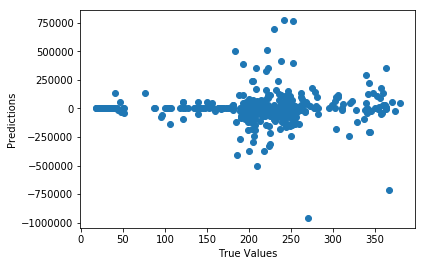

In [357]:
predictions = lr.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", lr.score(X_test, y_test))
plt.show()

In [359]:
xgb = XGBRegressor(gamma=0, learning_rate=0.02, max_depth=3, n_estimators=100)

In [360]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Score: 0.94280846105


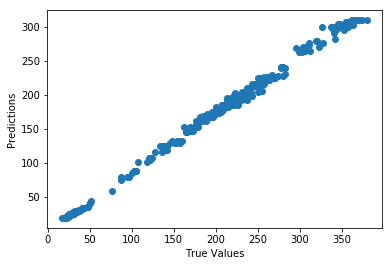

In [361]:
predictions = xgb.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", xgb.score(X_test, y_test))
plt.show()

In [363]:
accuracy = metrics.r2_score(y_test, predictions)
print("R2 Accuracy:", accuracy)

R2 Accuracy: 0.94280846105


In [364]:
print("MSE:", metrics.mean_squared_error(y_test, predictions))

MSE: 668.243820278


Damn!  But, how much is the NLP adding?

Score: 0.991110951772
MSE: 102.352151481


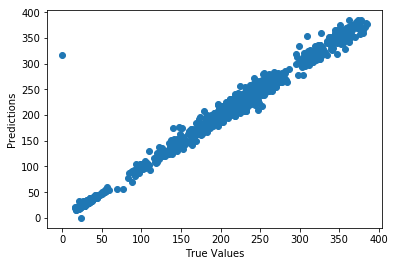

In [365]:
plt.scatter(stock.target, stock.forecast)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print("Score:", metrics.r2_score(stock.target, stock.forecast))
print("MSE:", metrics.mean_squared_error(stock.target, stock.forecast))
plt.show()

Hmmmm. I'm guessing my one outlier is just the last observation since it is probably a zero (using .shift() and there being nothing there).  So my SARIMAX model is accurate, but I sort of knew that already.

In [366]:
stock[['target', 'forecast']].sort_values('target').head()
# YUP, last entry

,target,forecast
date,,
2017-11-22,0.00,317.326469
2010-07-06,15.80,19.199988
2010-07-02,16.11,21.959973
2010-07-09,17.05,17.460010
2010-07-08,17.40,15.800004


In [367]:
print("Score:", metrics.r2_score(stock.iloc[:-1].target, stock.iloc[:-1].forecast))
print("MSE:", metrics.mean_squared_error(stock.iloc[:-1].target, stock.iloc[:-1].forecast))

Score: 0.995793097015
MSE: 48.414491673


And if I predicted the entirety with XGB:

In [368]:
print("MSE:", metrics.mean_squared_error(stock.target, xgb.predict(stock.drop(['target', 'close', 'open'], 1))))

MSE: 650.015530157


# Let's look at change

In [69]:
stock.head()

,close,volume,open,high,low,forecast,next_day_open,target,000 _news_,10 _news_,...,documentcloud.org,everythingiCafe,iDownloadBlog.com,iDownloadBlog.com iDownloadBlog.com,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists,predict_grow
date,,,,,,,,,,,,,,,,,,,,,
2010-06-29,23.89,18751150.0,19.00,25.0000,17.54,0.000000,25.79,23.83,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-06-30,23.83,17165210.0,25.79,30.4192,23.30,23.890019,25.00,21.96,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2010-07-01,21.96,8216789.0,25.00,25.9200,20.27,23.830008,23.00,19.20,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2010-07-02,19.20,5135795.0,23.00,23.1000,18.71,21.959973,20.00,16.11,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2010-07-06,16.11,6858092.0,20.00,20.0000,15.83,19.199988,16.40,15.80,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [369]:
stock['predict_grow'] = stock[['forecast', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)
stock['true_grow'] = stock[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [370]:
eval_sklearn_model(stock.true_grow, stock.predict_grow)

True Negative:  514 | False Positive:  443
False Negative:  472 | True Positive:  437 

Sensitivity (TP/ TP + FN):  0.480748074807
Specificity (TN/ TN + FP):  0.537095088819 

Accuracy:  0.509646302251
Precision:  0.496590909091




Shiiiiiiiiiit

Well that's the SARIMAX model on it's own... we can pray...

In [73]:
stock.columns

Index(['close', 'volume', 'open', 'high', 'low', 'forecast', 'next_day_open',
       'target', '000 _news_', '10 _news_',
       ...
       'everythingiCafe', 'iDownloadBlog.com',
       'iDownloadBlog.com iDownloadBlog.com', 'iLounge', 'iMore',
       'iPhone Hacks', 'iPhone in Canada Blog',
       'lists.swift.org Mailing Lists', 'predict_grow', 'true_grow'],
      dtype='object', length=3308)

In [371]:
X = stock.drop(['target', 'true_grow', 'predict_grow'], 1)
y = stock.true_grow

In [372]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [373]:
y.value_counts()

0    957
1    909
Name: true_grow, dtype: int64

In [81]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [82]:
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  98 | False Positive:  196
False Negative:  90 | True Positive:  176 

Sensitivity (TP/ TP + FN):  0.661654135338
Specificity (TN/ TN + FP):  0.333333333333 

Accuracy:  0.489285714286
Precision:  0.47311827957
Roc-Auc:  0.494878778579




In [84]:
start_time = t.time()

param_grid = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'gamma':[i/10.0 for i in range(0,5)]
             }

dt = XGBClassifier()

grid = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', verbose=1)

grid.fit(X_train, y_train)

best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_dt = grid.best_estimator_

best_dt = best_dt.fit(X_train, y_train)

score = best_dt.score(X_test, y_test)

#print('Number of Models Run: ', len(n_estimators) * len(max_features) * len(min_samples_leaf) * 3)
print("{} Score: {:0.3}".format('Decision Tree Classifier', score.mean().round(3)), '\n')
print('Elapsed Time: {:0.3}'.format( t.time() - start_time), ' seconds', '\n')
print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 56.4min finished


Decision Tree Classifier Score: 0.541 

Elapsed Time: 3.41e+03  seconds 

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Best Hyperparameters we tested for 
 {'params': [('gamma', 0.1), ('max_depth', 5), ('min_child_weight', 3)], 'score': 0.49469627234891383}


In [85]:
test_predictions = best_dt.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=best_dt, X=X_test)

True Negative:  148 | False Positive:  146
False Negative:  111 | True Positive:  155 

Sensitivity (TP/ TP + FN):  0.582706766917
Specificity (TN/ TN + FP):  0.503401360544 

Accuracy:  0.541071428571
Precision:  0.514950166113
Roc-Auc:  0.545515574651




In [87]:
import pickle

In [89]:
pickle.dump(best_dt, open('xgb_model.pkl', 'wb'))

## So how did we do?

```stock.iloc[1640]``` is 2017-01-03, the day I bought Tesla stocks

In [131]:
# Buy and hold strategy
stock.iloc[-2]['next_day_open'] - stock.iloc[1640]['next_day_open']

102.01999999999998

In [382]:
# SARIMAX Model predictions
profit_calculator(stock.iloc[1640:], 'predict_grow', -1)

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 54.59
Profit: $ 54.59
Number of Transactins: 102
Cost of transactions: $ 510


In [374]:
best_dt = pickle.load(open('xgb_model.pkl', 'rb'))

In [ ]:
stock['model_predict'] = best_dt.predict(stock.drop(['target', 'true_grow', 'predict_grow'], 1))

In [383]:
profit_calculator(stock.iloc[1640:], 'model_predict',-1)

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 314.105
Profit: $ 314.105
Number of Transactins: 86
Cost of transactions: $ 430


LIES!  This is has to be because I overfit and did not properly train/test split.  My model knows future news.

In [384]:
# True Possible returns
profit_calculator(stock.iloc[1640:], 'true_grow',-1)

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 620.08
Profit: $ 620.08
Number of Transactins: 118
Cost of transactions: $ 590


My model did perform positively, so that's something over the entire time period.  I did a different sort of train/test split which unfortunately won't work in the real world.  Currently it is buying even if change is 0 or up and selling if it is below 0.  With no transaction cost, this might make sense.

# Rebuild the Model from 2014 with proper train/test split

### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

In [9]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [10]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [11]:
# News sources binarize
mlb = MultiLabelBinarizer()

stock.news_sources = stock.news_sources.fillna('')
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

### SARIMAX

The time series model requires yesterday's data to make a prediction.  We will always have that information, so the model will essentially need to be retrained daily to incorporate it.  (There may be a way to feed the existing model new information, but I am not sure.). It therefore makes sense to create the predictions before the train test split as each prediction should only be dependent on data from prior days.

In [12]:
model_df = stock.iloc[915:].copy()

In [13]:
mod = sm.tsa.statespace.SARIMAX(model_df.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  951
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -2907.625
Date:                            Thu, 21 Dec 2017   AIC                           5827.249
Time:                                    10:40:54   BIC                           5856.394
Sample:                                02-18-2014   HQIC                          5838.353
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4877      0.792      0.616      0.538      -1.064       2.040
ma.L1         -0.4423      0.794     -0.557      0.577      -1.998       1.113
ma.L2          0.0137      0.055      0.251      0.802      -0.093       0.121
ma.L3         -0.0490      0.035     -1.386      0.166      -0.118       0.020
ma.S.L80      -0.9991      6.688     -0.149      0.881     -14.107      12.109
sigma2        37.3230    248.806      0.150      0.881    -450.328     524.974
===================================================================================
Ljung-Box (Q):                       22.88   Jarque-Bera (JB):               109.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.23
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
model_df['forecast'] = results.predict(dynamic=False)

In [15]:
model_df['target'] = model_df.close.shift(-1)
model_df['next_day_open'] = model_df.open.shift(-1) 
model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [16]:
model_df.news_text = model_df.news_text.fillna('')
model_df.tesla_tweet = model_df.tesla_tweet.fillna('')
model_df.elon_tweet = model_df.elon_tweet.fillna('')

### Train/test split

Split on ```model_df.iloc[725]``` as it is 2017-01-03

In [17]:
# Drop day one as no forecast can be made and last day as there is no "next_day_open"
train_df = model_df.iloc[1:725]
test_df = model_df.iloc[725:-1]

In [18]:
cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=2000)

# Fit news
cvec.fit(train_df.news_text)

# Transform train
cvec_df  = pd.DataFrame(cvec.transform(train_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = train_df.index
cvec_df.columns += " _news_"
train_df = train_df.join(cvec_df).drop('news_text',1)

# Transform test
cvec_df  = pd.DataFrame(cvec.transform(test_df.news_text.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = test_df.index
cvec_df.columns += " _news_"
test_df = test_df.join(cvec_df).drop('news_text',1)

# Fit tesla tweet
cvec.fit(train_df.tesla_tweet)

# Transform train
cvec_df  = pd.DataFrame(cvec.transform(train_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = train_df.index
cvec_df.columns += " _tesla_"
train_df = train_df.join(cvec_df).drop('tesla_tweet',1)

# Transform test
cvec_df  = pd.DataFrame(cvec.transform(test_df.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = test_df.index
cvec_df.columns += " _tesla_"
test_df = test_df.join(cvec_df).drop('tesla_tweet',1)

# Fit elon tweets
cvec.fit(train_df.elon_tweet)

# Transform train
cvec_df  = pd.DataFrame(cvec.transform(train_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = train_df.index
cvec_df.columns += " _elon_"
train_df = train_df.join(cvec_df).drop('elon_tweet',1)

# Transform test
cvec_df  = pd.DataFrame(cvec.transform(test_df.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
cvec_df.index = test_df.index
cvec_df.columns += " _elon_"
test_df = test_df.join(cvec_df).drop('elon_tweet',1)

### Alright, here we go!

In [19]:
train_df.head()

,close,volume,open,high,low,9to5Google,9to5Mac,@a_riley17,@aatilley,@adavies47,...,yet _elon_,yo _elon_,york _elon_,york http _elon_,youtube _elon_,yup _elon_,yup rt _elon_,zero _elon_,zqhjhtkuaj _elon_,zqhjhtkuaj http _elon_
date,,,,,,,,,,,,,,,,,,,,,
2014-02-19,193.64,16038700.0,203.70,203.70,193.41,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-20,209.97,18000940.0,215.01,215.21,206.27,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-21,209.60,7817352.0,211.64,213.98,209.19,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-24,217.65,8286273.0,208.76,218.36,208.32,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2014-02-25,248.00,32648710.0,230.00,259.20,228.45,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
X_train = train_df.drop(['target', 'true_grow'], 1)
y_train = train_df.true_grow

In [21]:
X_test = test_df.drop(['target', 'true_grow'], 1)
y_test = test_df.true_grow

In [22]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

In [23]:
xgb.fit(X_train, y_train)
test_predictions = xgb.predict(X_test)
eval_sklearn_model(y_test, test_predictions, model=xgb, X=X_test)

True Negative:  102 | False Positive:  14
False Negative:  82 | True Positive:  27 

Sensitivity (TP/ TP + FN):  0.247706422018
Specificity (TN/ TN + FP):  0.879310344828 

Accuracy:  0.573333333333
Precision:  0.658536585366
Roc-Auc:  0.577942106928




In [24]:
test_df['model_predict'] = test_predictions

In [25]:
profit_calculator(test_df, 'model_predict')

Own? False
Last Buying price: $ 299.5
Current price: $ 316.77
Cash? $ 63.9
Profit: $ 63.9
Number of Transactins: 54
Cost of transactions: $ 270


In [26]:
profit_calculator(test_df, 'true_grow')

Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 620.08
Profit: $ 620.08
Number of Transactins: 118
Cost of transactions: $ 590


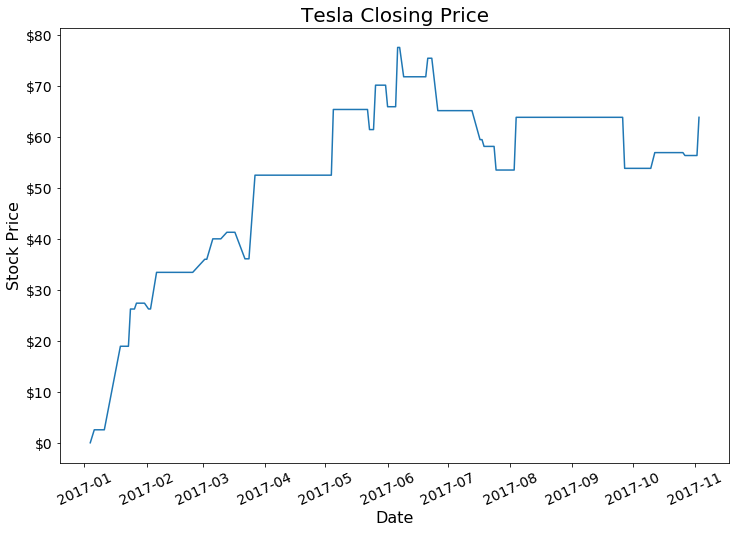

In [36]:
X, y = plot_profit(test_df, 'model_predict', early_stop=None)

In [39]:
# gridsearch xgboost
start_time = t.time()

param_grid = {'max_depth':range(3,10,2),
              'min_child_weight':range(1,6,2),
              'gamma':[i/10.0 for i in range(0,5)],
              'n_estimators':[100,500,1000]
             }

dt = XGBClassifier()

grid = GridSearchCV(dt, param_grid, cv=3, scoring='roc_auc', verbose=1)

grid.fit(X_train, y_train)

best_results = {'params': list(grid.best_params_.items()), 'score': grid.best_score_}

best_dt = grid.best_estimator_

best_dt = best_dt.fit(X_train, y_train)

score = best_dt.score(X_test, y_test)

#print('Number of Models Run: ', len(n_estimators) * len(max_features) * len(min_samples_leaf) * 3)
print("{} Score: {:0.3}".format('Decision Tree Classifier', score.mean().round(3)), '\n')
print('Elapsed Time: {:0.3}'.format( t.time() - start_time), ' seconds', '\n')
print(grid.best_estimator_, '\n')
print('Best Hyperparameters we tested for', '\n', best_results)

Fitting 3 folds for each of 180 candidates, totalling 540 fits


[Parallel(n_jobs=1)]: Done 540 out of 540 | elapsed: 686.3min finished


Decision Tree Classifier Score: 0.547 

Elapsed Time: 4.12e+04  seconds 

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Best Hyperparameters we tested for 
 {'params': [('gamma', 0.4), ('max_depth', 3), ('min_child_weight', 1), ('n_estimators', 100)], 'score': 0.51886353139604169}


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.4, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

Best Hyperparameters we tested for 
 {'params': [('gamma', 0.4), ('max_depth', 3), ('min_child_weight', 1), ('n_estimators', 100)], 'score': 0.51886353139604169}

# OH CRAP

I need to rebuild the model EVERY DAY!

# Rebuild the Model from 2014 with proper train/test split

### Note on earliest NLP relevant info
1. elon earliest tweet 2013-03-23
2. tesla earliest tweet 2014-02-18
3. techmeme earliest story 2006-12-07

```stock.iloc[915]``` is 2014-02-18

In [22]:
stock = pd.read_csv('TESLAHistoricalQuotes.csv')
stock = stock.drop(0,0)
stock.date = pd.to_datetime(stock.date)
stock.date = stock.date.apply(lambda x: x.date())
stock = stock.sort_values('date')
stock.volume = stock.volume.astype(float)
stock.set_index(stock.date, inplace=True)
stock = stock.drop('date', 1)

In [23]:
stock = pd.merge(stock, techmeme, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, tesla, how='left', left_index=True, right_index=True)
stock = pd.merge(stock, elon, how='left', left_index=True, right_index=True)

In [24]:
# News sources binarize
mlb = MultiLabelBinarizer()

stock.news_sources = stock.news_sources.fillna('')
stock = stock.join(pd.DataFrame(mlb.fit_transform(stock.news_sources), columns=mlb.classes_, index=stock.index))
stock = stock.drop('news_sources', 1)

### SARIMAX

The time series model requires yesterday's data to make a prediction.  We will always have that information, so the model will essentially need to be retrained daily to incorporate it.  (There may be a way to feed the existing model new information, but I am not sure.). It therefore makes sense to create the predictions before the train test split as each prediction should only be dependent on data from prior days.

In [25]:
model_df = stock.iloc[915:].copy()

In [26]:
mod = sm.tsa.statespace.SARIMAX(model_df.close, trend='n', order=(1,1,3), seasonal_order=(0,1,1,80))
results = mod.fit()
results.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                              close   No. Observations:                  951
Model:             SARIMAX(1, 1, 3)x(0, 1, 1, 80)   Log Likelihood               -2907.625
Date:                            Wed, 20 Dec 2017   AIC                           5827.249
Time:                                    21:16:05   BIC                           5856.394
Sample:                                02-18-2014   HQIC                          5838.353
                                     - 11-22-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4877      0.792      0.616      0.538      -1.064       2.040
ma.L1         -0.4423      0.794     -0.557      0.577      -1.998       1.113
ma.L2          0.0137      0.055      0.251      0.802      -0.093       0.121
ma.L3         -0.0490      0.035     -1.386      0.166      -0.118       0.020
ma.S.L80      -0.9991      6.688     -0.149      0.881     -14.107      12.109
sigma2        37.3230    248.806      0.150      0.881    -450.328     524.974
===================================================================================
Ljung-Box (Q):                       22.88   Jarque-Bera (JB):               109.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                            -0.23
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
model_df['forecast'] = results.predict(dynamic=False)

In [28]:
model_df['target'] = model_df.close.shift(-1)
model_df['next_day_open'] = model_df.open.shift(-1) 
model_df['true_grow'] = model_df[['target', 'next_day_open']].apply(lambda x: 1 if x[0] - x[1] >= 0 else 0, axis=1)

In [36]:
model_df.news_text = model_df.news_text.fillna('')
model_df.tesla_tweet = model_df.tesla_tweet.fillna('')
model_df.elon_tweet = model_df.elon_tweet.fillna('')

## WE REBUILD HERE

In [103]:
# We update this each time
real_test_df = model_df.iloc[725:-1].copy()
real_test_df['model_predict'] = np.NaN

### Train/test split

Split on ```model_df.iloc[725]``` as it is 2017-01-03

In [93]:
def count_vect_our_dfs(training_dataframe, testing_dataframe):
    cvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2), max_features=2000)

    # Fit news
    cvec.fit(training_dataframe.news_text)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.news_text.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _news_"
    training_dataframe = training_dataframe.join(cvec_df).drop('news_text',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.news_text.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _news_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('news_text',1)

    # Fit tesla tweet
    cvec.fit(training_dataframe.tesla_tweet)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _tesla_"
    training_dataframe = training_dataframe.join(cvec_df).drop('tesla_tweet',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.tesla_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _tesla_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('tesla_tweet',1)

    # Fit elon tweets
    cvec.fit(training_dataframe.elon_tweet)

    # Transform train
    cvec_df  = pd.DataFrame(cvec.transform(training_dataframe.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = training_dataframe.index
    cvec_df.columns += " _elon_"
    training_dataframe = training_dataframe.join(cvec_df).drop('elon_tweet',1)

    # Transform test
    cvec_df  = pd.DataFrame(cvec.transform(testing_dataframe.elon_tweet.dropna()).todense(), columns=cvec.get_feature_names())
    cvec_df.index = testing_dataframe.index
    cvec_df.columns += " _elon_"
    testing_dataframe = testing_dataframe.join(cvec_df).drop('elon_tweet',1)
    
    return training_dataframe, testing_dataframe

### Alright, here we go!

In [89]:
xgb = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1) 

In [104]:
for num, i in enumerate(range(725, 950)):
    train_df = model_df.iloc[1:i]
    test_df = model_df.iloc[i:i+1]
    train_cvec_df, test_cvec_df = count_vect_our_dfs(train_df, test_df)
    train_df = train_cvec_df
    test_df = test_cvec_df
    X_train = train_df.drop(['target', 'true_grow'], 1)
    y_train = train_df.true_grow
    X_test = test_df.drop(['target', 'true_grow'], 1)
    xgb.fit(X_train, y_train)
    real_test_df.iat[num, -1] = xgb.predict(X_test)

In [105]:
real_test_df

,close,volume,open,high,low,news_text,tesla_tweet,elon_tweet,9to5Google,9to5Mac,...,iLounge,iMore,iPhone Hacks,iPhone in Canada Blog,lists.swift.org Mailing Lists,forecast,target,next_day_open,true_grow,model_predict
date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,216.99,5901494.0,214.86,220.3300,210.9600,,,,0,0,...,0,0,0,0,0,214.345894,226.99,214.75,1,0.0
2017-01-04,226.99,11204560.0,214.75,228.0000,214.3100,,battery cell production begin at the gigafacto...,,0,0,...,0,0,0,0,0,216.666821,226.75,226.42,1,1.0
2017-01-05,226.75,5908927.0,226.42,227.4800,221.9500,,,hold-down firing of @spacex falcon 9 at vanden...,0,0,...,0,0,0,0,0,229.154491,229.01,226.93,1,1.0
2017-01-06,229.01,5524153.0,226.93,230.3100,225.4500,,,@pensasoda http t co 6ies7xbubs via @wired,0,0,...,0,0,0,0,0,225.668192,231.28,228.97,1,1.0
2017-01-09,231.28,3972716.0,228.97,231.9200,228.0000,,,,0,0,...,0,0,0,0,0,227.879001,229.87,232.00,0,0.0
2017-01-10,229.87,3658981.0,232.00,232.0000,226.8900,chris lattner join tesla a vp of autopilot sof...,welcome chris lattner http t co aaig6rhhdf,rt @teslamotors welcome chris lattner http t c...,0,1,...,0,1,1,1,1,232.658214,229.73,229.07,1,0.0
2017-01-11,229.73,3649910.0,229.07,229.9800,226.6800,,,@redletterdave the least cool character it s e...,0,0,...,0,0,0,0,0,231.287654,229.59,229.06,1,1.0
2017-01-12,229.59,3787547.0,229.06,230.7000,225.5800,,,@brandonr182 @sama have you tried steam engine...,0,0,...,0,0,0,0,0,229.386931,237.75,230.00,1,1.0
2017-01-13,237.75,6085610.0,230.00,237.8500,229.5900,,building the supercharger network for the futu...,rt @spacex tracking ground wind for tomorrow s...,0,0,...,0,0,0,0,0,227.790621,235.58,236.70,0,1.0


In [111]:
eval_sklearn_model(real_test_df.true_grow, real_test_df.model_predict)

True Negative:  77 | False Positive:  39
False Negative:  60 | True Positive:  49 

Sensitivity (TP/ TP + FN):  0.449541284404
Specificity (TN/ TN + FP):  0.663793103448 

Accuracy:  0.56
Precision:  0.556818181818




In [112]:
print('Model Profit:')
profit_calculator(real_test_df, 'model_predict')
print('\nBest Case Profit:')
profit_calculator(real_test_df, 'true_grow')

Model Profit:
Own? False
Last Buying price: $ 302.5
Current price: $ 316.77
Cash? $ 74.01000000000005
Profit: $ 74.01000000000005
Number of Transactins: 104
Cost of transactions: $ 520

Best Case Profit:
Own? False
Last Buying price: $ 310.86
Current price: $ 316.77
Cash? $ 620.0799999999999
Profit: $ 620.0799999999999
Number of Transactins: 118
Cost of transactions: $ 590
